# This file explores clustering of the latent vectors
# It is organised as follows:
* extract latent vectors from VAE model and save
* attempt at t-distributed Stochastic Neighbour Embedding (t-SNE) and Principal Component Analysis (PCA)
    * did not produce good visual results in 2 dimensions
* elbow graph for k-Means clustering to justify use of 100 clusters
* print example clusters and find most malignant and most benign clusters
* find further statistics about clusters

In [1]:
base = 128
batch_size = 128

In [2]:
# IMPORTS 

# Torch for data loading and for model buiding
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
#from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

# Data preprocessing
import pandas as pd
from pandas.io.json import json_normalize
import json
import os
import re

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.colors as pltcols
import seaborn as sns
import scipy.stats as stats 
from PIL import Image
from pylab import rcParams

# Maths
import math
import numpy as np

# Other
from time import perf_counter
import time
from collections import Counter,OrderedDict
import random
import warnings

# Clustering
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


# Load VAE model to extract latent vectors

In [3]:
# Check if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
IMAGE_DIR = r"C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\Data\Images"


all_files_list = [f for f in os.listdir(IMAGE_DIR)]
all_files_list.sort()
        
print(len(all_files_list))
print(all_files_list[0:10])

13852
['0001_NI000_slice000.npy', '0001_NI000_slice001.npy', '0001_NI000_slice002.npy', '0001_NI000_slice003.npy', '0001_NI000_slice004.npy', '0001_NI000_slice005.npy', '0001_NI000_slice006.npy', '0001_NI000_slice007.npy', '0002_NI000_slice000.npy', '0002_NI000_slice001.npy']


In [5]:
def parameter_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
# Create class to load image data from files
class LoadImages(Dataset):
    def __init__(self, main_dir, files_list):
        # Set the loading directory
        self.main_dir = main_dir

        # Transforms
        self.transform = transforms.Compose([transforms.ToTensor()])

        # Get list of all image file names
        self.all_imgs = files_list
        
    def __len__(self):
        # Return the previously computed number of images
        return len(self.all_imgs)    

    def __getitem__(self, index):
        # Get image location
        img_loc = self.main_dir + self.all_imgs[index]
        # Represent image as a tensor
        img = np.load(img_loc)
        # scaling idea from https://www.mdpi.com/2076-3417/10/21/7837
        # set all air (<-1000) to 0 and all bone (>400) to 1, scale all other numbers to between [0,1] 
        img = np.where((-1000 <= img) & (img <= 400), (img - - 1000)/(400 - - 1000), img)
        img[img<-1000] = 0
        img[img>400] = 1
        img = self.transform(img) 
        return img

# Load image data using LoadImages class
images = LoadImages(main_dir=IMAGE_DIR + '/', files_list=all_files_list)
print('number of images:',len(images))
data_split = random_split(images, [11000,2852], generator=torch.Generator().manual_seed(42))
train_images = data_split[0]
test_images = data_split[1]
train_loader = DataLoader(train_images, batch_size, shuffle=True)
test_loader = DataLoader(test_images, batch_size, shuffle=False)
image_loader = DataLoader(images, batch_size, shuffle=False)

number of images: 13852


In [7]:
# definition of vae model
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x):
        return self.conv(x)

class ConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvTranspose, self).__init__()
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x):
        return self.conv(x)

#https://distill.pub/2016/deconv-checkerboard/
#  the checkerboard could be reduced by replacing transpose convolutions with bilinear upsampling
class ConvUpsampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvUpsampling, self).__init__()
        
        self.scale_factor = kernel_size
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        
    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear')
        return self.conv(x)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
       
        # output_width = [ (input_width - kernel_width + 2*padding) / stride ] + 1
        self.encoder = nn.Sequential(
            Conv(1, base, 3, stride=1, padding=1),        # (64 - 3 + 2)/1 + 1  = 64
            Conv(base, 2*base, 3, stride=1, padding=1),   # 64
            Conv(2*base, 2*base, 3, stride=2, padding=1), # (64 - 3 + 2)/2 + 1 = 32
            Conv(2*base, 2*base, 3, stride=1, padding=1), # 32
            Conv(2*base, 4*base, 3, stride=2, padding=1), # (32 - 3 + 2)/2 + 1 = 16
            Conv(4*base, 4*base, 3, stride=1, padding=1), # 16
            Conv(4*base, 4*base, 3, stride=2, padding=1), # (16 - 3 + 2)/2 + 1 = 8
            nn.Conv2d(4*base, 32*base, 8),                # (8 - 8 + 0)/1 + 1 = 1
            nn.GELU()
        )
        self.encoder_mu = nn.Conv2d(32*base, 16*base, 1) # (1 - 1)/1 + 1 = 1    ## 32*base = 32*4 = 128  ### 1*512 = 512
        self.encoder_logvar = nn.Conv2d(32*base, 16*base, 1)

        # Conv2d_output_width = [ (input_width - kernel_width + 2*padding) / stride ] + 1
        # ConvTranspose_output_width =(input_width −1)*stride − 2*in_padding + dilation*(kernel_width−1) + out_padding +1
        self.decoder = nn.Sequential(
             nn.Conv2d(16*base, 32*base, 1),                       # (1 - 1)/1 + 1 = 1                              ## 32 64
             ConvTranspose(32*base, 4*base, 8),                    # (1-1)*1 + 2*0 + 1(8-1) + 0 + 1  = 8     ## 64 4         
             Conv(4*base, 4*base, 3, padding=1),                   # (8 - 3 + 2)/1 + 1 = 8                          ## 4 4 
             ConvUpsampling(4*base, 4*base, 4, stride=2, padding=1),# (8-1)*2 - 2*1 + 1(4-1) + 0 + 1 = 16     ## 4 4         
             Conv(4*base, 2*base, 3, padding=1),                   # (16 - 3 + 2)/1 + 1 = 16                        ## 4 2 
             ConvUpsampling(2*base, 2*base, 4, stride=2, padding=1),# (16-1)*2 - 2*1 + 1(4-1) + 0 + 1 = 32    ## 2 2         
             Conv(2*base, base, 3, padding=1),                     # 32                                             ## 2 1  
             ConvUpsampling(base, base, 4, stride=2, padding=1),    # (32-1)*2 - 2*1 + 1*(4-1) + 0 + 1 = 64   ## 1 1 
             nn.Conv2d(base, 1, 3, padding=1),                     # 64                                             ## 1 1
            nn.Tanh()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        return self.encoder_mu(x), self.encoder_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) 
        eps = torch.randn_like(std) # mean=0 , std=1
        #z = mu + logvar*self.N.sample(mu.shape)
        return mu + eps*std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

print('parameter count:', parameter_count(VAE()))

parameter count: 310337025


In [8]:
model = VAE().to(device)
model.load_state_dict(torch.load(r"C:\Users\mm17b2k\Results\VAE_results7.0\VAE_params.pt", map_location=torch.device('cpu'))["state_dict"])
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv(
      (conv): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU()
      )
    )
    (1): Conv(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU()
      )
    )
    (2): Conv(
      (conv): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU()
      )
    )
    (3): Conv(
      (conv): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.

In [9]:
data = next(iter(image_loader)).float()
print(data.shape)
encoded = model.encoder(data)
print(encoded.shape)
mu = model.encoder_mu(encoded)
print(mu.shape)
log_var = model.encoder_logvar(encoded)
print(log_var.shape)

torch.Size([128, 1, 64, 64])
torch.Size([128, 4096, 1, 1])
torch.Size([128, 2048, 1, 1])
torch.Size([128, 2048, 1, 1])


In [10]:
mus = []
log_vars = []
with torch.no_grad():
    for batch_idx, data in enumerate(image_loader):
        data = data.float().to(device)
        encoded = model.encoder(data)
        mu_batch = model.encoder_mu(encoded)
        log_var_batch = model.encoder_logvar(encoded)
        for mu in mu_batch:
            mus.append(torch.squeeze(torch.squeeze(mu, dim=1), dim=1).tolist())
        for log_var in log_var_batch:
            log_vars.append(torch.squeeze(torch.squeeze(log_var, dim=1), dim=1).tolist())

print(len(mus))
print(len(log_vars))

13852
13852


In [11]:
np.save(r"C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\LIDC\Python Scripts\latent vectors" + '/' + 'mu', mus)
np.save(r"C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\LIDC\Python Scripts\latent vectors" + '/' + 'log_var', log_vars)

In [12]:
mus = np.load(r"C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\LIDC\Python Scripts\latent vectors\mu.npy")
log_var = np.load(r"C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\LIDC\Python Scripts\latent vectors\log_var.npy")

# t-SNE and PCA exploration

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 88.96194710000418 seconds


Text(0, 0.5, 'Dimension 2')

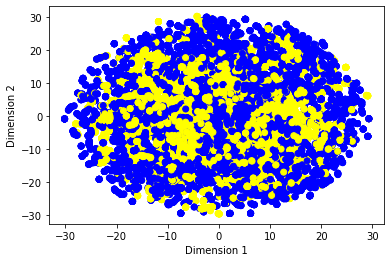

In [15]:
labels = np.load(r"C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\LIDC\Python Scripts\latent vectors\labels2.npy")

time_start = perf_counter()
tsne_images = TSNE(perplexity=10,learning_rate=8).fit_transform(mus)
time_stop= perf_counter()

print('t-SNE done! Time elapsed: {} seconds'.format(time_stop-time_start))
tsne_images.shape
colours = ['blue','yellow']
x = [tsne[0] for tsne in tsne_images]
y = [tsne[1] for tsne in tsne_images]
plt.scatter(x, y, c=labels, cmap=pltcols.ListedColormap(colours))
#plt.scatter(x,y, c=labels, label=labels)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# Graph produced does not show clear seperation of data into clusters
# different 'perplexity' values produce different plots (some with less clear speration)


PCA done! Time elapsed: 0.8286112000059802 seconds


Text(0, 0.5, 'Dimension 2')

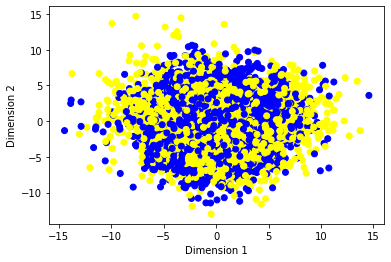

In [14]:
time_start = perf_counter()
pca = PCA(n_components=2)
principal_component = pca.fit_transform(mus)
time_stop= perf_counter()

print('PCA done! Time elapsed: {} seconds'.format(time_stop-time_start))
x = [com[0] for com in principal_component]
y = [com[1] for com in principal_component]
colours = ['blue','yellow']
plt.scatter(x, y, c=labels, cmap=pltcols.ListedColormap(colours))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')


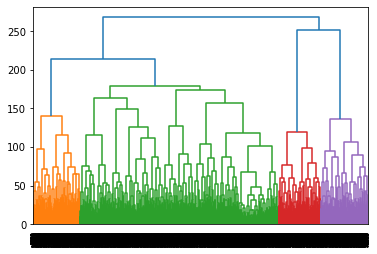

In [13]:
dendrogram = sch.dendrogram(sch.linkage(mus, method='ward'))

# K-Means clustering 

Text(0.5, 1.0, 'Elbow Graph for 2-50 clusters')

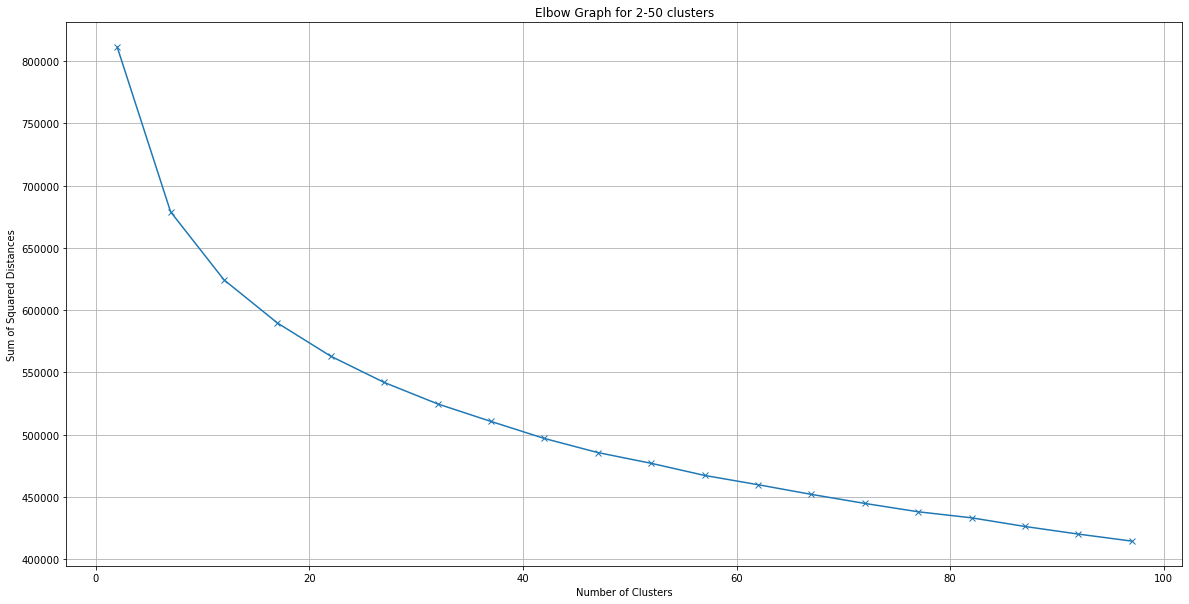

In [65]:
distortions = []
for k in range(2,102,5):
    k_means = KMeans(n_clusters = k)
    k_means.fit(mus)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize = (20,10))
plt.plot(range(2,102, 5), distortions, marker='x')
plt.grid(True)
plt.ylabel('Sum of Squared Distances')
plt.xlabel('Number of Clusters')
plt.title('Elbow Graph for 2-50 clusters')

Text(0.5, 1.0, 'Elbow Graph for 2-502 clusters')

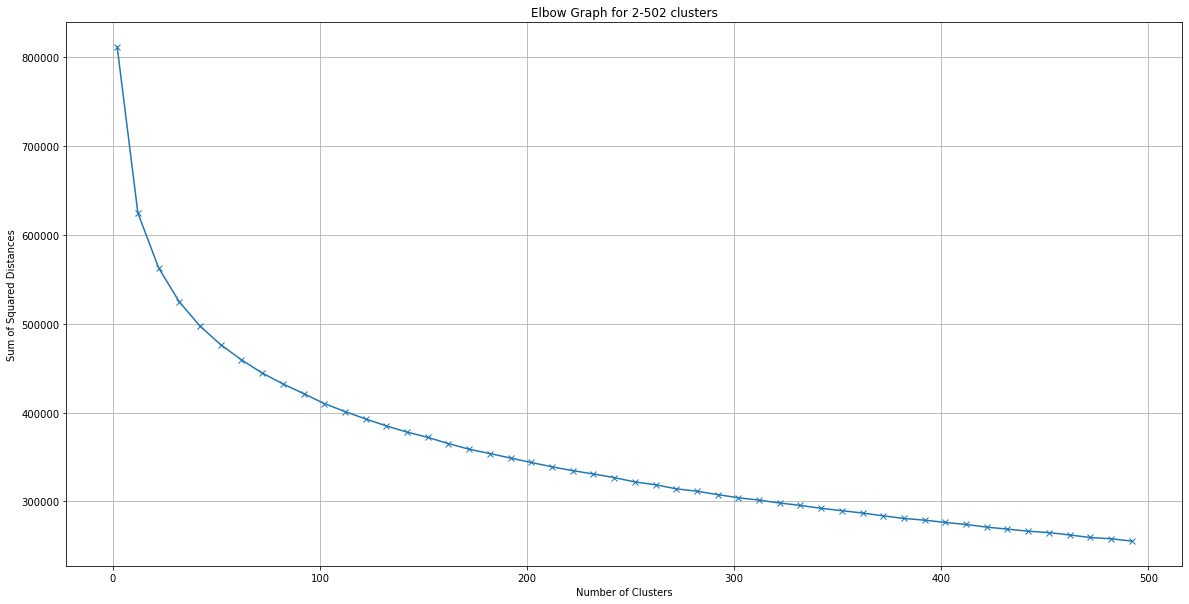

In [66]:
distortions = []
for k in range(2,502,10):
    k_means = KMeans(n_clusters = k)
    k_means.fit(mus)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize = (20,10))
plt.plot(range(2,502, 10), distortions, marker='x')
plt.grid(True)
plt.ylabel('Sum of Squared Distances')
plt.xlabel('Number of Clusters')
plt.title('Elbow Graph for 2-502 clusters')

In [ ]:
# try gap statistic 

In [19]:
def view_img(files):
    plt.figure(figsize=(10,10))
    for i, image in enumerate(files):
        plt.subplot(4,4,i+1)
        img = np.load(IMAGE_DIR+'/'+image)
        plt.imshow(img)
        plt.grid()
    plt.show()

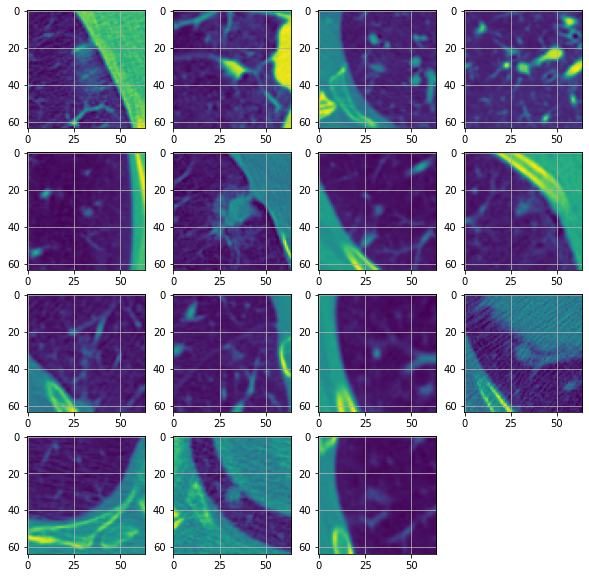

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100)
kmeans.fit(mus)
kmeans_dict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
kmeans_dict
index_1, index_2, index_3, index_4, index_5 = [], [], [], [], []
for j in range(16):
    index_1.append(random.choice(kmeans_dict[0]))
    index_2.append(random.choice(kmeans_dict[1]))
    index_3.append(random.choice(kmeans_dict[2]))
    index_4.append(random.choice(kmeans_dict[3]))
    index_5.append(random.choice(kmeans_dict[4]))

files_1, files_2, files_3, files_4, files_5 = [], [], [], [], []
for i, v in enumerate(all_files_list):
    if i in index_1:
        files_1.append(v)
    if i in index_2:
        files_2.append(v)
    if i in index_3:
        files_3.append(v)
    if i in index_4:
        files_4.append(v)
    if i in index_5:
        files_5.append(v)
view_img(files_1)

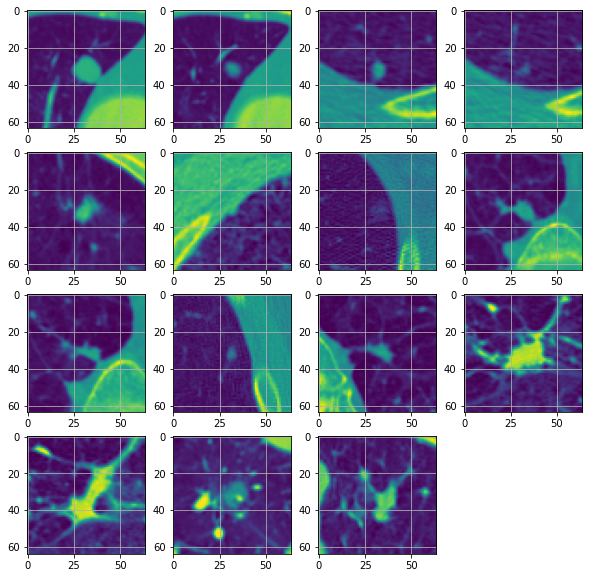

In [78]:
view_img(files_2)

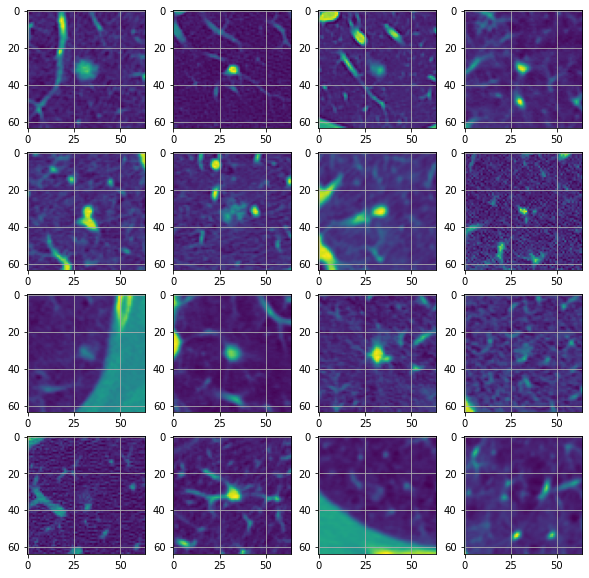

In [79]:
view_img(files_3)

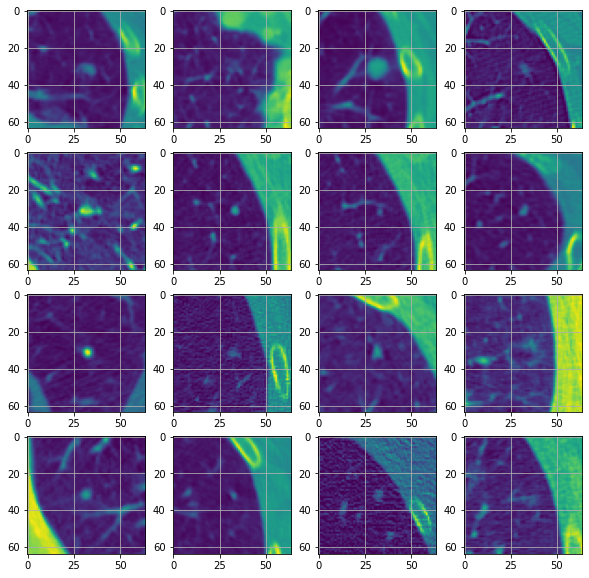

In [80]:
view_img(files_4)

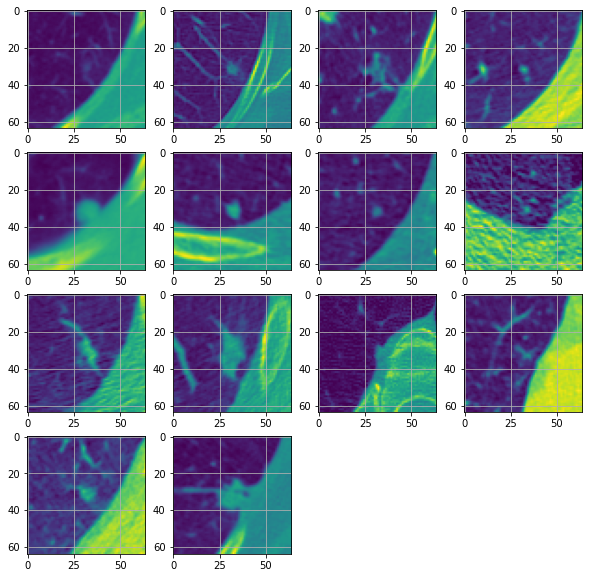

In [81]:
view_img(files_5)

In [25]:
kmeans_dict[0] # first cluster

array([  120,   440,   441,   725,   726,   727,   787,   788,   824,
        1053,  1377,  1380,  1386,  1387,  1388,  1389,  1410,  1411,
        1412,  1418,  1527,  1576,  1657,  1670,  1671,  1760,  1836,
        1837,  1893,  2089,  2555,  2556,  2616,  2814,  2815,  2856,
        3105,  3132,  3212,  3330,  3433,  3688,  3689,  3690,  3858,
        3994,  3995,  3996,  4007,  4167,  4227,  4228,  4235,  4236,
        4237,  4244,  4342,  4343,  4344,  4345,  4346,  4348,  4507,
        4508,  4722,  4733,  4734,  4810,  4811,  4817,  4818,  4819,
        4826,  4836,  4943,  5861,  5884,  5888,  5889,  6030,  6031,
        6032,  6033,  6034,  6116,  6117,  6118,  6153,  6177,  6178,
        6212,  6213,  6940,  6941,  7238,  7508,  7592,  8294,  8295,
        8339,  9050,  9275,  9283,  9285,  9704,  9705,  9706,  9707,
        9708,  9709,  9710,  9711,  9712,  9713,  9714,  9715,  9716,
        9717,  9718,  9883,  9885, 10442, 10443, 10444, 10445, 10446,
       10679, 10689,

In [218]:
data_2classes = np.load(r'C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\LIDC\Python Scripts\latent vectors\data_2classes.npy')
#data_2classes = data_2classes.tolist()
data_3classes = np.load(r'C:\Users\mm17b2k\Documents\ARCANE\Python\MSc\LIDC\Python Scripts\latent vectors\data_3classes.npy')
#data_3classes = data_3classes.tolist()

In [219]:
len(data_2classes)

13852

In [308]:
proportions = []
for key in kmeans_dict:
    num_cancer = 0
    for item in kmeans_dict[key]:
        num_cancer += data_2classes[item][2]
    proportions.append(num_cancer/len(kmeans_dict[key]))

In [309]:
proportions[22]

0.8645833333333334

In [310]:
proportions[76]

0.08403361344537816

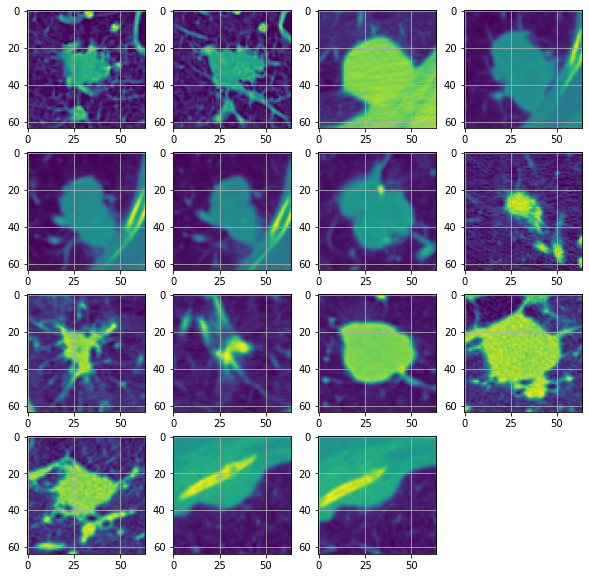

In [314]:
index_malignant, index_benign, files_malignant, files_benign = [], [], [], []
for j in range(16):
    index_benign.append(random.choice(kmeans_dict[76]))
    index_malignant.append(random.choice(kmeans_dict[22]))

for i, v in enumerate(all_files_list):
    if i in index_malignant:
        files_malignant.append(v)
    if i in index_benign:
        files_benign.append(v)
        
view_img(files_malignant)

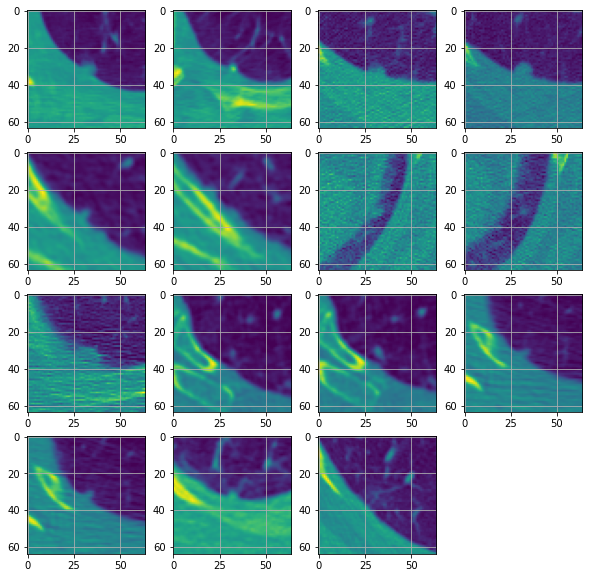

In [315]:
view_img(files_benign)

In [336]:
#3 classes
proportions_cancer = []
proportions_ambig = []
proportions_benign = []

for key in kmeans_dict:
    num_cancer = 0
    num_ambig = 0
    num_benign = 0
    for item in kmeans_dict[key]:
        if data_3classes[item][2] == 2:
            num_cancer += 1
        if data_3classes[item][2] == 1:
            num_ambig += 1
        if data_3classes[item][2] == 0:
            num_benign += 1
    proportions_cancer.append(num_cancer/len(kmeans_dict[key]))
    proportions_ambig.append(num_ambig/len(kmeans_dict[key]))
    proportions_benign.append(num_benign/len(kmeans_dict[key]))
    
print(max(proportions_cancer),max(proportions_ambig),max(proportions_benign))

0.8645833333333334 0.6666666666666666 0.49523809523809526


In [316]:
low_high = 0
for prop in proportions:
    if prop < 0.33 or prop > 0.67:
        low_high +=1
low_high

53

In [318]:
ids = np.unique(data_2classes[::,1])
len(ids)

875

In [343]:
print('number of patients in most malignant/benign clusters:',len(patient_id_slice[22]), len(patient_id_slice[76]))

number of patients in most malignant/benign clusters: 11 13


In [ ]:
data_2classes = np.array(data_2classes)
ids = np.unique(data_2classes[::,1])
patient_id_slice = []
for i in ids:
    indices = np.where(i==data_2classes[::,1])
    patient_id_slice.append(list(indices[0]))
patient_id_slice[0:5]

In [ ]:
locations = []
for id_list in patient_id_slice:
    patient_locations = []
    for ids in id_list:
        for key in kmeans_dict:
            for item in kmeans_dict[key]:
                if ids == item:
                    patient_locations.append(key)
    if len(patient_locations) > 0:
        locations.append(patient_locations)
locations[0:5]

In [322]:
len(locations)

875

In [323]:
num_clusters = []
one_cluster = 0
over_50_percent = 0
over_50_in_2clusters = 0
over_25_percent = 0
for locs in locations:
    if len(np.unique(locs)) == 1:
        one_cluster += 1
    if max(np.bincount(locs)) > 0.5*len(locs):
        over_50_percent += 1
    if max(np.bincount(locs)) > 0.25*len(locs):
        over_25_percent += 1
        #print(locs)
    if (max(np.bincount(locs)) + np.sort(np.bincount(locs))[-2]) > 0.5*len(locs):
        over_50_in_2clusters += 1
    
    num_clusters.append([len(np.unique(locs)), len(locs)])
print(one_cluster, 'patients are in only 1 cluster')
print(over_50_percent, 'patients are at least 50% in 1 cluster')
print(over_25_percent, 'patients are at least 25% in 1 cluster')
print(over_50_in_2clusters, 'patients are at least 50% across 2 clusters')
#num_clusters

102 patients are in only 1 cluster
240 patients are at least 50% in 1 cluster
624 patients are at least 25% in 1 cluster
546 patients are at least 50% across 2 clusters
